# Matilda Quickstarter

# Introduction

Matilda is an open-source R pakcage that provides the Hector simple climate model with a probabilistic analysis framework. Just like Hector, Matilda has applictions, the most prominent of which is to generate large ensembles to explore parameter uncertainties. Additionally, Matilda provides an ensemble weighting methodology for climate projections. This can be used to weight ensemble members based on how closely they represent historic data. 

This vignette will walk through the usage of Matilda with example of the important functions and useful ways to visualize the results. This vignette assumes that Matilda, Hector, and dependancies are already installed. The for Matilda code repository can be accessed [here](https://github.com/JGCRI/matilda/tree/main/R) and a software description can be accessed [here](https://journals.plos.org/climate/article?id=10.1371/journal.pclm.0000295).


# Set-up

First, load the `matilda` package. If you have not installed `matilda` before, you will first need to install using `devtools::install_github("jgcri/matilda")`

In [1]:
library(matilda)

Loading required package: hector



In [2]:
# quiet messaging
options(matilda.verbose = F)

# plot settings
options(repr.plot.width = 12, repr.plot.height = 8)

## Configure Hector core

Next, we will initialize a "core" for a new Hector instance. 
More information about establishing a new core for running Hector can be found in the tutorial for using the [Hector R interface](https://jgcri.github.io/hector/articles/intro-to-hector.html).


In [3]:
# Read INI file with emission scenario of interest and create a new core
ini <- system.file("input/hector_ssp245.ini", package = "hector")

c_ssp245 <- newcore(ini, name = "SSP2-4.5")


This new Hector core is a self-contained object with information about Hector inputs and outputs.


## Generate parameter values

In Matilda we can generate parameter values using `generate_params()`. The purpose of this function is to sample parameter values form pre-defined distributions, some of the distirbutions are assumed to be normal while others are assumed to be lognormal. The mean of the distributions is defined using parameter values from Hector (note that the version of Hector you are running will affect what these distributions). The standard deviation of the distirbutions is based on the scientific literature.

In Matilda we currrently have parameter distributions defined for 6 parameters that have significant control over the behavior of Hector's carbon cycle. These parameters include:

- `BETA` - CO2 fertilization factor. This parameter adjusts the efficiency of plant carbon uptake. With higher values of `BETA` more carbon is drawn from the atmosphere and stored in the land sink by way of vegetatie productivity.

- `Q10_RH` - Heterotrophic respiration temperature sensitivity factor. This parameter adjusts how heterotrophic respiration reponds to warming. Higher levels of `Q10_RH` indicate higher sensitivity to warming which could lead to more carbon released from microbial activity.

- `NPP_FLUX0` - Initial net primary productivity flux. This parameter sets the initial baseline plant productivity.

- `AERO_SCALE` - Aerosol scaling factor. This is a unitless scale factor used to adjust Hector's temperature sensitivity to aerosol radiative forcing. Higher values of this parameter inidcate increased temperature sensitivity to aerosols.

- ` DIFFUSIVITY` - Ocean heat diffusivity. This parameter controls the rate heat diffuses into the deep ocean. Higher values of this parameter indicates more efficient heat diffusion and could lead to more moderate warming. 

- `ECS` - Equilibrium climate sensitivity. Characterizes Hector's long-term temperature response to chnages in atmospheric CO2 concentrations. 

The first argument in `generate_params` is the Hector core we are working form, the scond is the number of `draws` or samples we want to generate. Parameter samples are drawn from respective distributions randomly using a Monte Carlo method.


In [4]:
# Generate a data frame of random parameter values
set.seed(245)

param_values <- generate_params(c_ssp245, draws = 20)

head(param_values, 5)


,BETA,Q10_RH,NPP_FLUX0,AERO_SCALE,DIFFUSIVITY,ECS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6753931,2.2756429,60.91701,0.9328857,2.539807,3.929521
2,0.4573796,6.9471032,63.71816,0.6875820,2.420622,2.800992
3,0.3327026,1.4457176,51.26192,1.1166160,2.434140,2.866165
4,0.6798939,1.6260931,53.36137,0.6808227,2.386139,2.872652
5,0.3946660,0.6354375,54.15588,0.8333346,2.439274,2.624341


We now have a data frame object with 20 random values sampled for each parameter.

We call these perturbed parameter sets and each parameter set can each be used for a single Hector run to produce a simulation. 

It may be of interest to only randomly sample a few model parameters while keeping all other parameters static. This type of control is easily enforcible by manipulating columns in our `param_values` data frame. 

For example, if we are only interested in perturbing CO2 fertilization (`BETA`) and ocean heat diffusivity (`DIFFUSIVITY()`), we can simply drop all other columns in the `param_values` data frame. This leaves only the parameters we want to perturbe when building the ensemble of model runs.


In [5]:
# producing data frame to only manipulate BETA and DIFFUSIVITY
alter_beta_diff <- param_values[c(1, 5)]

head(alter_beta_diff)


,BETA,DIFFUSIVITY
,<dbl>,<dbl>
1,0.6753931,2.539807
2,0.4573796,2.420622
3,0.3327026,2.434140
4,0.6798939,2.386139
5,0.3946660,2.439274
6,0.5215754,2.438615


In these cases, all other parameters will follow Hector defaults when running the ensemble.

# Running Hector iteratively

Running the Hector simple climate model iteratively with slightly different parameters for each run (from our `param_values`) is the first really cool design feature of Matilda. This function will use the perturbed parameter set to run Hector simulations, resulting in a perturbed parameter ensemble (PPE). 

To run the model and build the PPE we call `iterate_model()`.

Running `iterate_model()` requires a core and a data frame of parameter values. In this tutorial we will use the core and parameter values we established earlier.

In [6]:
# Run Hector repeatedly over all parameter values
results <- iterate_model(
  core = c_ssp245,
  params = param_values
)

head(results)


,scenario,year,variable,value,units,run_number
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<int>
1,SSP2-4.5,1745,CO2_concentration,277.1500,ppmv CO2,1
2,SSP2-4.5,1746,CO2_concentration,277.1872,ppmv CO2,1
3,SSP2-4.5,1747,CO2_concentration,277.2201,ppmv CO2,1
4,SSP2-4.5,1748,CO2_concentration,277.2503,ppmv CO2,1
5,SSP2-4.5,1749,CO2_concentration,277.2784,ppmv CO2,1
6,SSP2-4.5,1750,CO2_concentration,277.3046,ppmv CO2,1


By default the function returns the Hector default climate variables `CO2_concentration`, `RF_CO2`, `RF_tot`, and `global_tas` for the Hector default years 1745-2300. This results in a data frame object with 44,480 rows: 10 samples * 556 years * 4 variables.

Users can adjust the output to suite their needs by calling the `save_vars` and `save_years` arguments in `iterate_model`. This will subset the data frame object to to the years and variables identified. 

_When planning the output of your PPE; 1) take into consideration the variables that you need. Matilda is built around Hector and therefore can fetch any output variables that Hector produces. 2) Consider the years that you will need in the ouput. Do not cut the years of your ouput too short, this can cause issues down the road depending on your use of the data._   

We can plot the results easily in `ggplot2`.

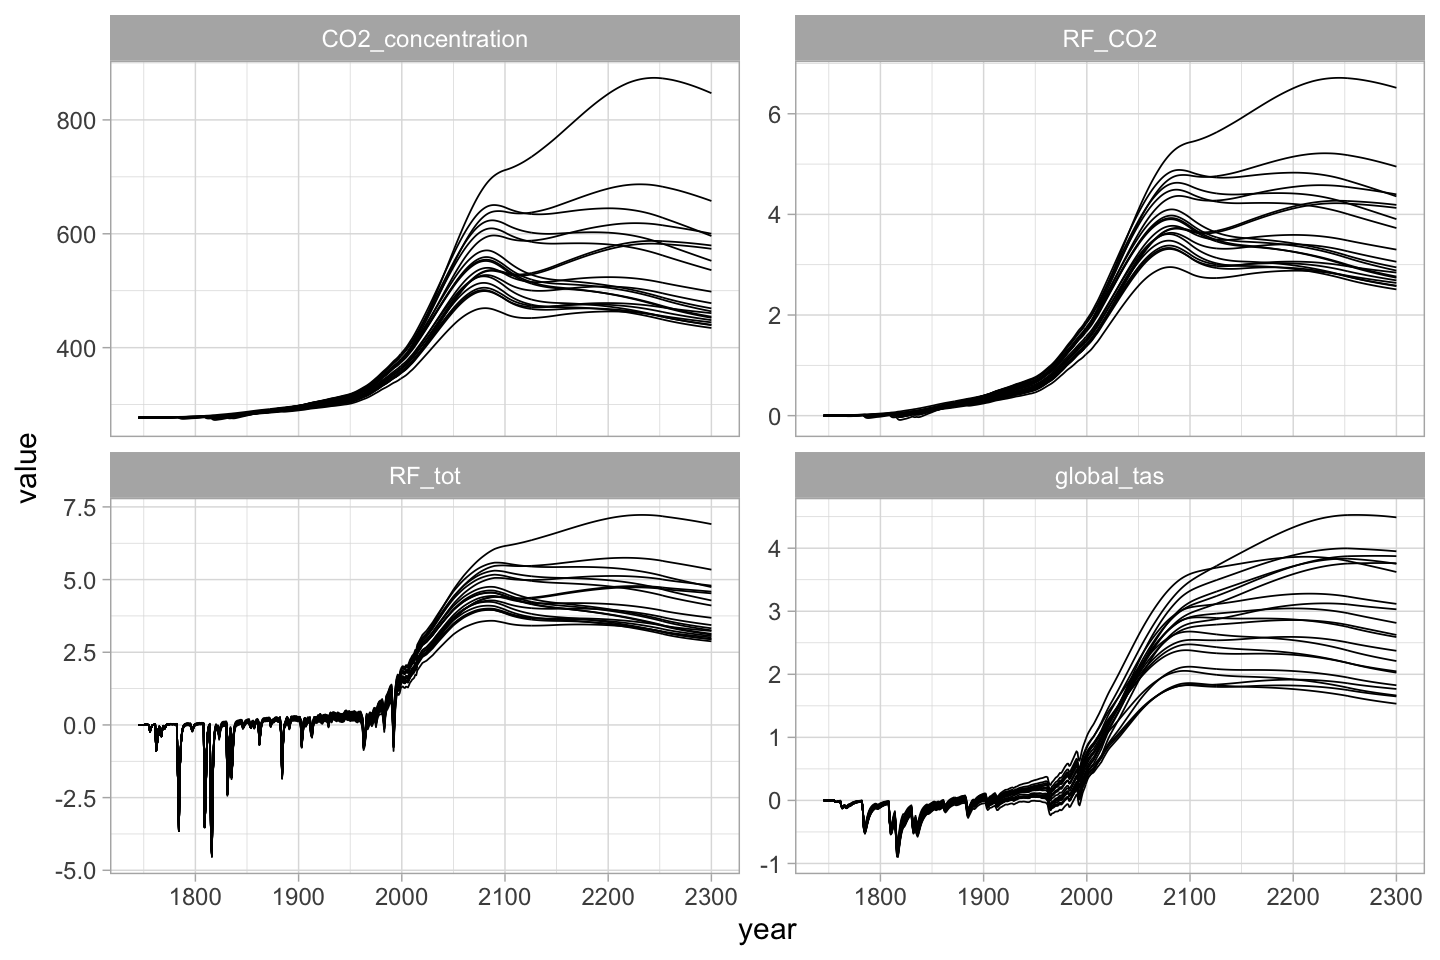

In [7]:
library(ggplot2)

ggplot(data = results,
       aes(x = year, y = value, group = run_number)) +
  geom_line() +
  facet_wrap(~variable, scales = "free_y") +
  theme_light(base_size = 18)


From the plot, we can see that we have a PPE of Hector runs. Each Plotted line is a member of the ensemble and we can see from the spread of the runs that there is an effect when we incorporate parameter uncertainty into simulations. 

As these results stand, each member in the ensemble is contributing equal information to the range of possible outcomes. However, there are likely some memebers in this ensemble that are not accurate in representing the Earth system. This occurs because some of the random parameter sets used to produce the ensemble yeild unrealistic model response. For this reason, we can constrain, score, and weight ensemble members to highlight those that are most likely accurate.

# Scoring and weighting results

The Next biggest design feature in Matilda is the ability to score, weight, and constraint PPEs. It is important that we score ensemble members against historic data and/or future climate from Earth System Models (see e.g. [Goodwin and Cael 2021](https://esd.copernicus.org/articles/12/709/2021/)). This allows us to 1) discard any models that are not realistic representations of the Earth system and 2) weight the models that perform the best so that further ananlysis is as accurate as possible.

In Matilda there are functions that compute a score for each PPE member, these scores are then used to compute normalized weights for each ensemble member, representing the likelihood of each ensemble member.

Scoring members of a PPE requires a **scoring criterion**. In Matilda, a **scoring criterion** is an object fo class `criterion` used as evidence in scoring ensemble members. Matilda gives the user the ability to create their own criterion using any dataset they supply. New criterion are built by calling `new_criterion()`. 

Here we provide an arbitrary example to show how `new_criterion` can work (this specific example in nonsensical and should not be used for an analysis):


In [8]:
# Create a new criterion 
# In this case, we set up a global temperature criterion, with the 'observations'
# running from 1951 to 2000
my_criterion <- new_criterion(GLOBAL_TAS(),
  years = 1951:2000,
  obs_values = seq(0.4, 1.0, length.out = 50)
)

my_criterion


Criterion for screening Hector:  global_tas 1951  to  2000 

We cand see by printing `my_criterion` that a new criterion is being stored that will use the data we provided to score ensemble members by `global_tas` in the years 1951-2000 printed.

Matilda also provides criterion baked into the package. These include:

- `criterion_co2_obs()` - Uses historic CO2 observations from the [Mauna Loa atmospheric CO2 observatory](https://gml.noaa.gov/ccgg/trends/).

- `criterion_gmst_obs()` - Uses [HadCRUT5](https://metoffice.gov.uk/hadobs/hadcrut5) global historical surface temperature anomalies mean global surface temperature anomalies realtive to a 1961-1990 reference period.

For sake of simplicity in this tutorial, we will use a single criterion to weight our esemble (`criterion_co2_obs()`). However, it is important to note that to take full advantage of Matilda's model scoring/weighting mechanism, multiple criteria can, and should be used.

To compute scores for our ensemble, we call `score_runs()`. This function uses our PPE, scoring criterion, and a **scoring function** to compute a score for each ensemble member. A **scoring function** is an algorithm that computes a score for for each ensemble memeber based on how well the ensemble fits the criterion. Those scores are then normalized as part of `score_runs()`, producing the model weights. 

Matilda currently has two provided scoring functions:

- `score_ramp()`

- `score_bayesian()`

For the  purposes of this tutorial we will be calling `score_ramp` as our scoring function.

`score_ramp` will ramp down an ensemble member's score linearly as it deviates from observations. It determines the acceptable deviation with user supplied bounds. For example, we can create an instance where ensemble members with differences $\le$ the `w1` parameter will score 1.0, while members with differences $\ge$ `w2` will score 0.0, and ensmeble members scores decrease linearly between `w1` to `w2`.


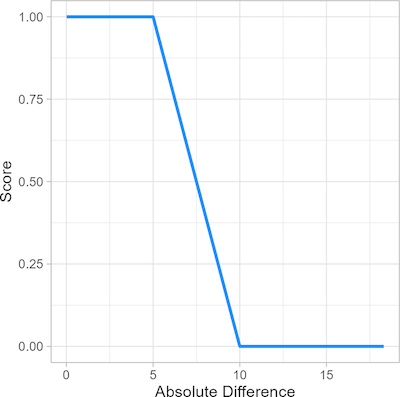

The figure provides a simple example of how `score_ramp` computes scores betweeen two bounds.

Here, we score/weight our ensemble for members that are within 2-5 ppm of our observed atmospheric CO2 concentration criterion.

In [9]:
# Score ensemble with observed CO2 data
scores <- score_runs(results, 
                     criterion_co2_obs(), 
                     score_ramp, 
                     w1 = 2, w2 = 5)

head(scores)


,weights,run_number
,<dbl>,<int>
1,0.00000000,1
2,0.02385940,2
3,0.00000000,3
4,0.14173687,4
5,0.00000000,5
6,0.01533292,6


The result of the scoring process is a new data frame object with a weight calculated for each ensemble member (indicated by `run_number`). Ensemble members that did not fall within the acceptable range $\ge$ 5 ppm deviation from the scoring criterion are give a score of 0 (culled from contributing information to probabilistic calculation). Ensemble members which closely replicate historic data in our criterion have weights closer to 1. 

After merging our wieghts to our full PPE results, we can visualize the weighted ensemble members, highlighting those PPE members that were closest to our scoring criterion:


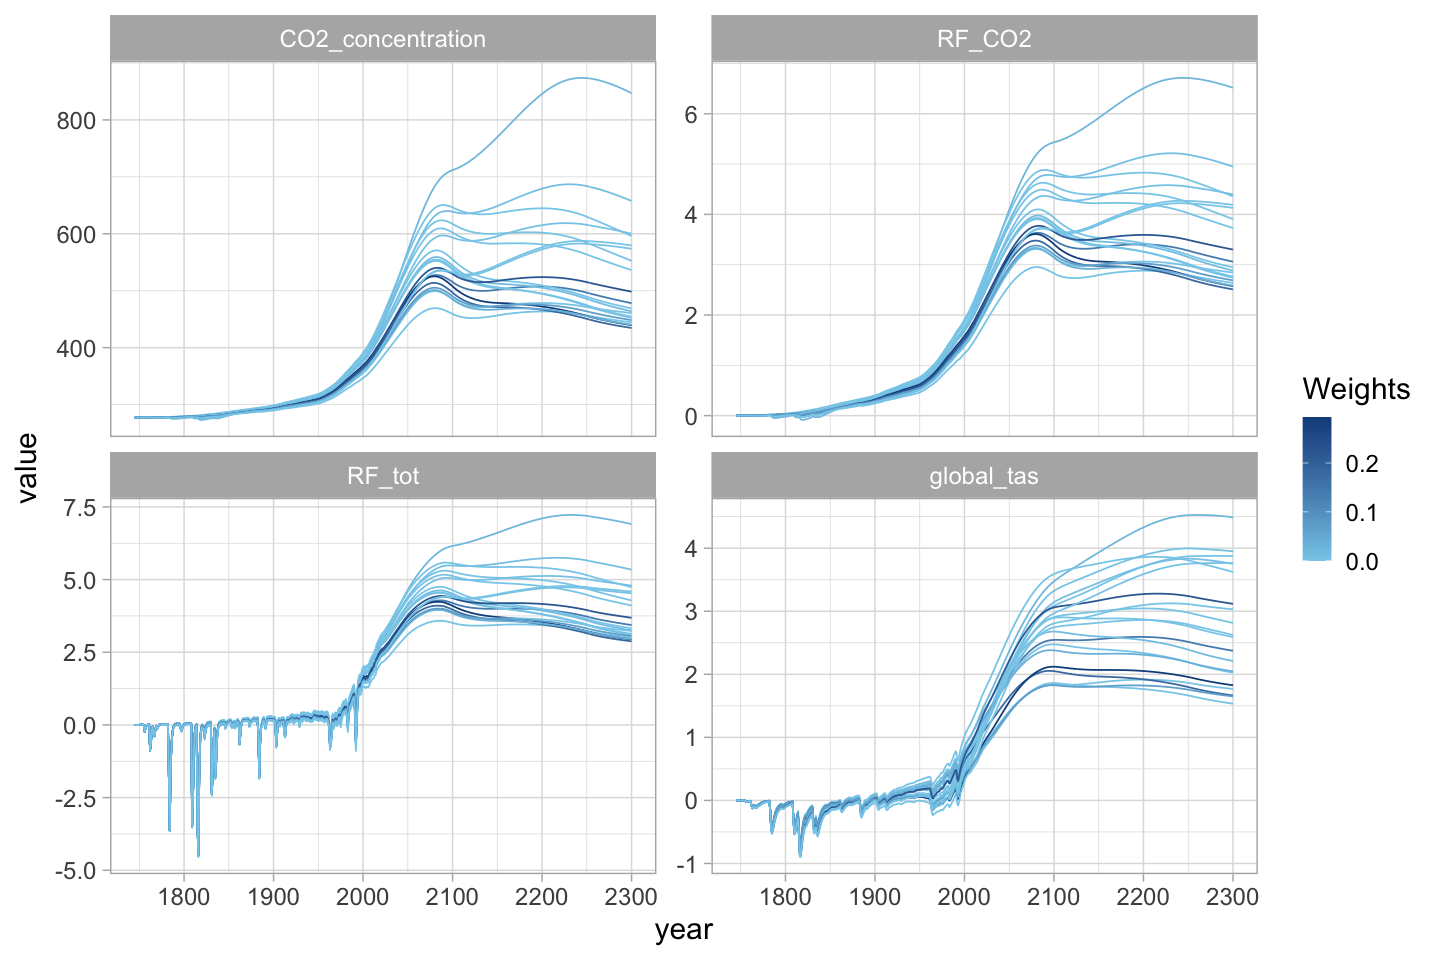

In [10]:
# Merge results with model scores
results_scored <- merge(results, scores, by = "run_number")

ggplot(data = results_scored) +
  geom_line(aes(x = year, y = value, group = run_number, color = weights)) +
  scale_color_gradient(low = 'skyblue', high = 'dodgerblue4', name = "Weights") +
  #scale_alpha_continuous(range(c(0.8, 1)), name = NULL) +
  facet_wrap(~variable, scales = "free_y") +
  theme_light(base_size = 18)


With this visualization, we can see that ensmeble members with lower scores (more deviation from our criterion) are in lighter blue. These are ensemble members that do not fit historical data well and therefore should be excluded from contributing information to probabilistic projections.

With this process we are able to begin to constain our PPE for the most realistic simulations.

# Defining and calculating climate metrics

The next cool feature Matilda provides is an easy-to-use mechanism for summarizing climate metrics from PPEs. For instance, we can calculate the median warming for the 2090-2100 period. This tells us the amount of warming in the last decade of the century relative to some historical period (this requires some post-processing). A **metric** value is computed for each ensemble member.

In order to use this feature, we first have to call `new_metric()` to define the climate metric we want to use. This function takes three arguments; 1) the climate variable we want to summarize, 2) the year range for the metric, and 3) an operation to implement (mean, meadian, etc.). This will create a metric object

In this tutorial we will call `new_metric()` to create metric for median `global_tas` or GSAT (global mean air temperature) for the 2090:2100 period. 


In [11]:
# Define a new_metric object for Hector analysis
my_metric <- new_metric(GLOBAL_TAS(), 2090:2100, median)

print(my_metric)


Probabilistic Hector Metric:  median global_tas 2090  to  2100 


Printing the object we can see that we have now defined this metric object and it is ready for use.

After defining a new metric, we can call `metric_calc()` and use it to compute metric values for each ensemble member. Running `metric_calc()` requires two arguments: 1) our PPE results and 2) our fully defined metric (`my_metric`):


In [12]:
# Compute metric values
metric_values <- metric_calc(results, my_metric)

head(metric_values)


,run_number,metric_result
,<int>,<dbl>
1,1,3.045121
2,2,3.411633
3,3,2.877593
4,4,2.538214
5,5,2.471132
6,6,2.673802


The result is a data frame object with a `metric_result` for each member of the ensemble.

This data can be used in several ways. First, it can be used to compute warming quantiles. For example, we can use the entire ensemble to compute median future warming with a _very likely_ range (5-95% CI) weighted by our ensemble weights.

In Matilda we have provided a function that directly summarizes weighted probabilities for future climate changes.


# Weighted probabilistic projections

So far we have discussed how to build a PPE by applying parameter uncertainty, weighting/scoring/constraining ensembles against historical or modeled data, and how to use the PPE memebers to summarize the analysis. 

Here we will cover one more cool feature of Matilda, computing probabilities. In this framework, we can call `prob_calc()` to compute probabilities of future climate change according to our PPE metrics and weights. During this process Matilda takes user defined ranges (or "bins") and sorts the PPE based on the metric value, summing PPE member weights as they are sorted. 

We can use our previous metric of `median global_tas for 2090-2100` to compute probabilities of specific warming ranges: 

In [13]:
# Establish temp ranges for binning metric values
temp_ranges <- c(0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, Inf)

# Calculate probabilities for global_tas
prob_results <- prob_calc(metric_values$metric_result,
                          bins = temp_ranges,
                          scores = scores$weights)
prob_results <- prob_results[, -2]
prob_results$scenario <- "SSP2-4.5"
prob_results

bins,probability,scenario
<fct>,<dbl>,<chr>
"(1.5,2]",0.06883374,SSP2-4.5
"(2,2.5]",0.51301226,SSP2-4.5
"(2.5,3]",0.15779406,SSP2-4.5
"(3,3.5]",0.26035994,SSP2-4.5
"(3.5,4]",0.00000000,SSP2-4.5


Because `prob_calc()` bins each metric and sums the weights of each PPE member as it is binned, it can use the summed weight of each bin to compute the probability of each climate variable outcome.

The result shows the likelihood that median temperature anomaly for each of the temperature ranges we defined. 

**Note**: These results are simply to show how the package is used and should not be taken as true projections of future warming. 

We can visualize these probabilities in a popular stacked bar format, where the length of the bar (100%) is partitioned by the probability of each warming range:

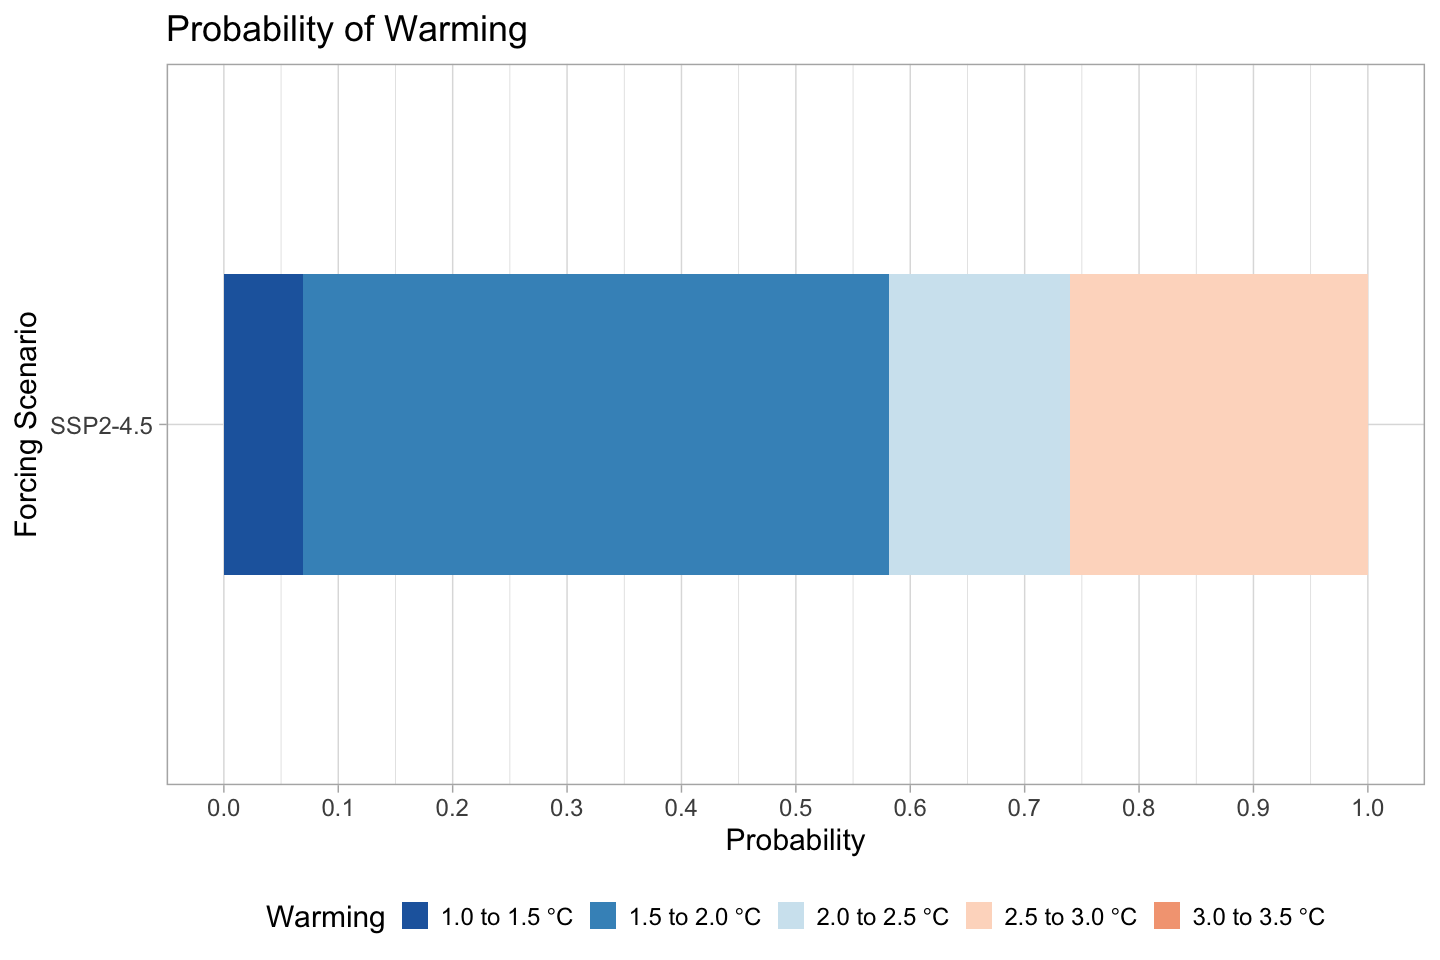

In [14]:
temp_cols <- c("#2166AC","#4393C3","#D1E5f0","#FDDBC7","#F4A582","#D6604D","#B2182B","#67001F") 
probability_plot <- ggplot(data = prob_results,
                          aes(fill = bins,
                              x = scenario, 
                              y = probability)) +
                    geom_bar(position = position_fill(reverse = T),
                             stat = "identity",
                             width = 0.5) +
                    scale_y_continuous(breaks = seq(0.0, 1.0, 0.1)) +
                    scale_fill_manual(
                    values = temp_cols, 
                    labels = c(expression(paste("1.0 to 1.5", ~degree, "C")),
                               expression(paste("1.5 to 2.0", ~degree, "C")),
                               expression(paste("2.0 to 2.5", ~degree, "C")),
                               expression(paste("2.5 to 3.0", ~degree, "C")),
                               expression(paste("3.0 to 3.5", ~degree, "C")),
                               expression(paste("3.5 to 4.0", ~degree, "C")),
                               expression(paste("4.0 to 4.5", ~degree, "C")),
                               expression(paste(" > 4.5", ~degree, "C"))),
                        name = "Warming") +
                    labs(y = "Probability",
                         x = "Forcing Scenario", 
                         title = "Probability of Warming") +
                    coord_flip() + 
                    theme_light(base_size = 18) + 
                    theme(legend.position = "bottom")
probability_plot

# The whole game

The Hector simple climate model runs very quickly. The computational efficiency is what makes this framework posible. Using the Hector/Matilda combination makes it easier to run probabilistic analyses on multple SSP-RCP scenarios at once using the `apply()` family of functions in `R`.

The following chunks of code runs a top to bottom Matilda instance for each of four SSP scenarios (SSP1-1.9, SSP2-4.5, SSP3-7.0, and SSP5-8.5), using a very modest number of parameter sets. For simplicity we continue to weight the PPE members with a single scoring criterion (`criterion_gmst_obs()`), but this time with the `score_bayesian()` function.


## Initiating

In [99]:
# locate the ini directory
ini_dir <- paste0(system.file("input", package = "hector"), "/")

# read in ini files into a list
ini_list <- list(ssp119 = paste0(ini_dir, "hector_ssp119.ini"),
                 ssp245 = paste0(ini_dir, "hector_ssp245.ini"),
                 ssp370 = paste0(ini_dir, "hector_ssp370.ini"),
                 ssp585 = paste0(ini_dir, "hector_ssp585.ini"))

## Parameter generation

In [100]:
# Using generate_params() to build the perturbed parameter set

# set seed for replication
set.seed(123)

# set sample size (we will run with a small sample size for now)
n = 40

# initiate a core using the first ini file in ini_list
params_core <- newcore(ini_list[[1]])

# produce parameter set 
params <- generate_params(core = params_core,
                          draws = n)

## Running Model

In [101]:
# using element names in ini_list, loop through each scenario_name and run the model
model_results <- lapply(names(ini_list), function(scenario_name){
  
  # extract scenario information from each element in the ini_list by 
  # scenario name
  scenario = ini_list[[scenario_name]]
  
  # initiate core for the scenario
  core = newcore(scenario, name = scenario_name)
  
  # run the model 
  result = iterate_model(core = core, 
                         params = params, 
                         save_years = 1800:2100,
                         save_vars = GMST())
  
})

## Model Scoring and Weighting

In [102]:
# loop through results in model_results to compute model weights for each 
score_list <- lapply(model_results, function(df){
  
  # use observed temperature to compute model weights
  scores_temp <- score_runs(df, 
                            criterion = criterion_gmst_obs(),
                            score_function = score_bayesian)
})

In [103]:
# merge results df in model_results with the corresponding scores in score_list 
# by the run_number column
scored_result_list <- Map(merge, model_results, score_list, by = "run_number")

# bind the elements in scored_result_list to build data frame for plotting
scored_result_df <- do.call(rbind, scored_result_list)

## Computing Metrics

In [104]:
my_metric <- new_metric(var = GMST(), years = 2090:2100, op = median)

In [107]:
# loop through results and compute metrics for each
metric_list <- lapply(model_results, function(df){
  
  # calculate metrics using the metric we defined in the previous step
  metric_calc(df, my_metric)
  
})

# merge the metrics_list dfs with score_list 
scored_metric_list <- Map(merge, metric_list, score_list, by = "run_number")

## Computing Probabilities

In [108]:
# Define metric ranges
temp_ranges <- c(1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, Inf)

# compute probabilities for each element in metric_list
probability_result <- lapply(scored_metric_list, function(df){
  
  # use prob_calc to compute probabilities
  prob_calc(metrics = df$metric_result,
            bins = temp_ranges,
            scores = df$weights)
  
})

In [109]:
# scenario names
scenario_id <- c("ssp119", "ssp245", "ssp370", "ssp585")

# Use Map to add scenario names to metric_list()
probability_result <- Map(function(df, scenario_id){

  # add scenario column and add corresponding scenario id in the scenario_id vector
  df$scenario <- scenario_id
  
  return(df)
  
}, probability_result, scenario_id)

In [112]:
# bind results to data frame
probability_result_df <- do.call(rbind, probability_result)

## Plotting the results

#### Plot visualizing ensemble weights 

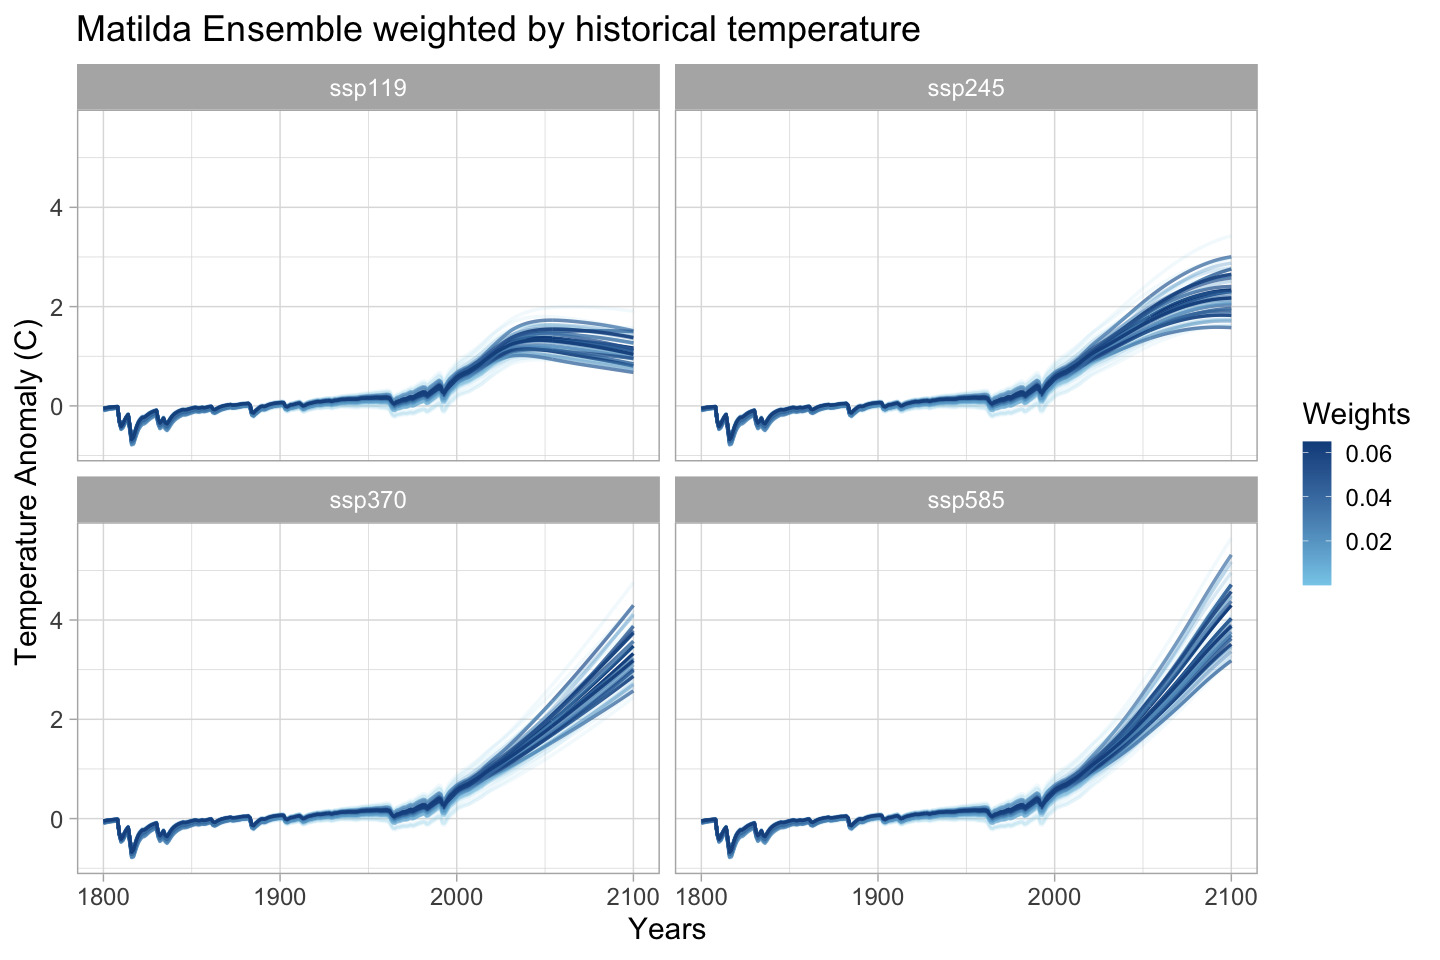

In [117]:
gmst_projection_plot <- 
  ggplot(data = scored_result_df) + # sets the plotting environment
  geom_line( # identifies plot type
    aes(
      x = year, # identifies x-axis variable
      y = value, # identifies y-axis variable
      group = run_number, # identifies how data should be grouped
      color = weights, # how color should be applied
      alpha = weights), # how transparency should be applied
    linewidth = 1) + # sets line width - personal preference
  scale_color_gradient(low = "skyblue", high = "dodgerblue4", name = "Weights") + # what colors should be used
  scale_alpha_continuous(range(c(0.5, 1))) + # how extreme should the transparency gradient be - this is optional
  guides(alpha = "none") + # remove alpha legend 
  facet_wrap(~ scenario) + # panels the figure by scenario name
  labs(x = "Years", y = "Temperature Anomaly (C)") + # adds labels to axes
  ggtitle(label = "Matilda Ensemble weighted by historical temperature") +
  theme_light(base_size = 18) # sets a general theme - personal preference 

gmst_projection_plot

#### Plot visualizing warming probabilities

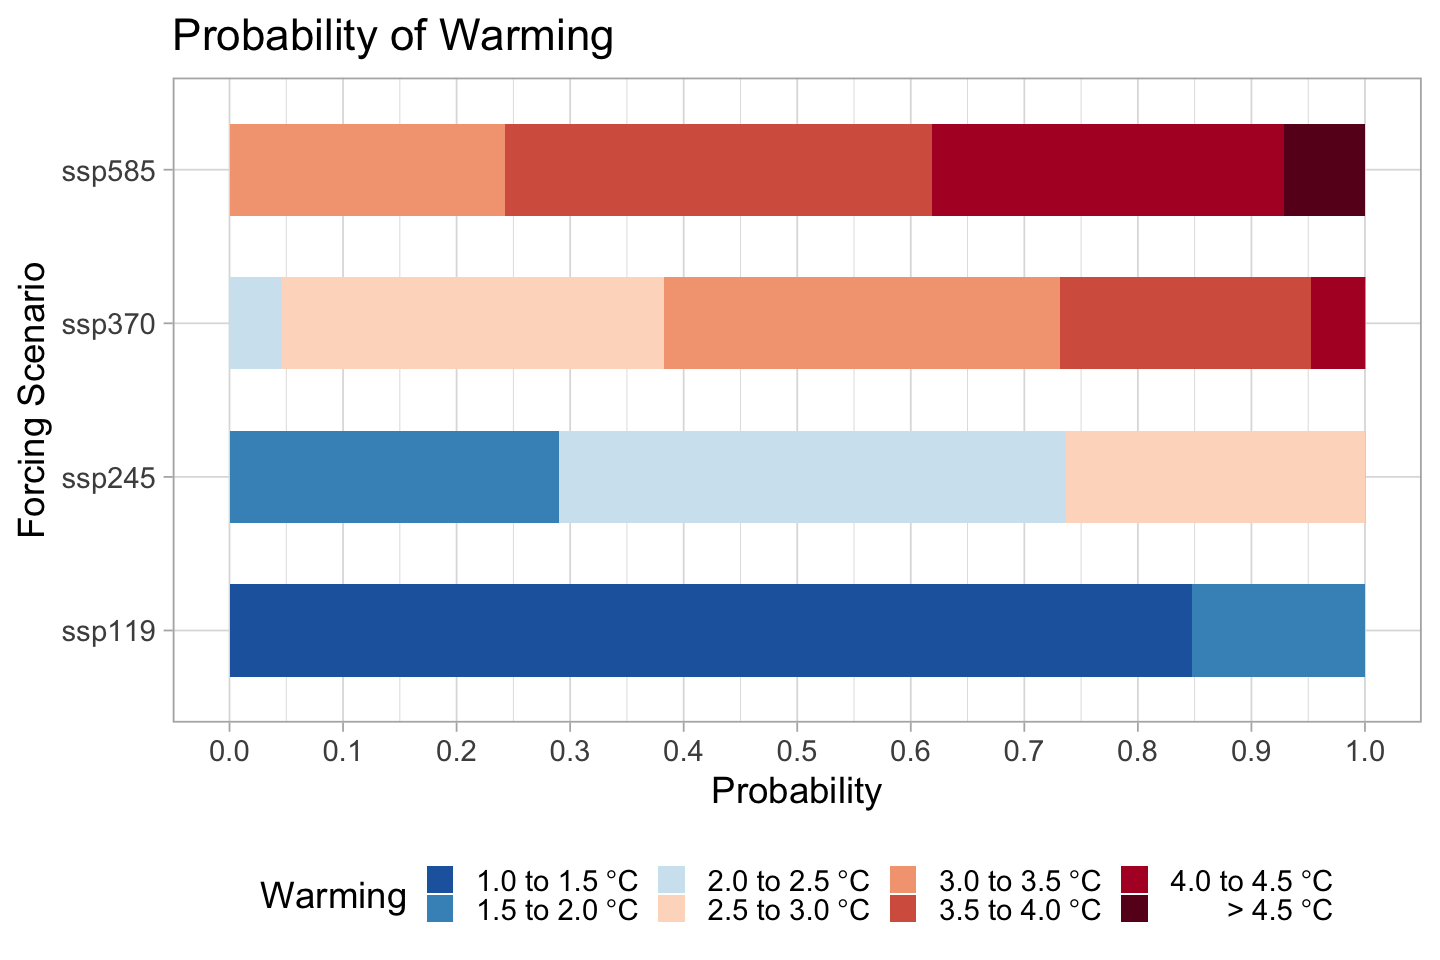

In [120]:
temp_cols <- c("#2166AC","#4393C3","#D1E5f0","#FDDBC7","#F4A582","#D6604D","#B2182B","#67001F") 

probability_plot <- 
  ggplot(data = probability_result_df, # identify the data location
         aes(
           fill = bins, # how fill should be applied
           x = scenario, # what data goes on the x-axis
           y = probability)) + # what data goes on the y-axis
  # below we will be flipping the coord of the figure so right now the axes seem 
  # backwards from what we want.
  geom_bar(position = position_fill(reverse = T), # what type of plot we want and reverse the 
                                                  # stack order so cooler temps are on left
           stat = "identity", # we want the width of the bar pieces to be constrained by a value in the data
           width = 0.6) + # how wide do you want the bar - personal preference
  scale_y_continuous(breaks = seq(0.0, 1.0, 0.1)) + # set the number and interval of probability breaks
  scale_fill_manual(
    values = temp_cols, # indicate the color palette to use
    labels = c(         # edit labels for the legend
      expression(paste("1.0 to 1.5", ~degree, "C")),
      expression(paste("1.5 to 2.0", ~degree, "C")),
      expression(paste("2.0 to 2.5", ~degree, "C")),
      expression(paste("2.5 to 3.0", ~degree, "C")),
      expression(paste("3.0 to 3.5", ~degree, "C")),
      expression(paste("3.5 to 4.0", ~degree, "C")),
      expression(paste("4.0 to 4.5", ~degree, "C")),
      expression(paste(" > 4.5", ~degree, "C"))),
    name = "Warming") + # name of the legend
  labs(y = "Probability",
       x = "Forcing Scenario", 
       title = "Probability of Warming") +
  coord_flip() + # flip the coordinates of the figure to make horizontal representation
  theme_light(base_size = 22) + # set theme - personal preference 
  theme(legend.position = "bottom") # change legend position - personal preference

probability_plot

For more information about Matilda and other JGCRI tools please visit the [JGCRI GitHub Page](https://github.com/JGCRI)